### MARIO FERNANDEZ BUSTO
### JUAN JOSE JIMENEZ DE JUAN
### JORGE CHAMORRO PEDROSA

# LOAD DATASET

In [43]:
from ucimlrepo import fetch_ucirepo 
  
# Fetch dataset 
bone_marrow_transplant_children = fetch_ucirepo(id=565) 
  
# Data (as pandas dataframes) 
X = bone_marrow_transplant_children.data.features 
y = bone_marrow_transplant_children.data.targets 
  
# Metadata 
print(bone_marrow_transplant_children.metadata) 
  
# Variable information 
print(bone_marrow_transplant_children.variables)

{'uci_id': 565, 'name': 'Bone marrow transplant: children', 'repository_url': 'https://archive.ics.uci.edu/dataset/565/bone+marrow+transplant+children', 'data_url': 'https://archive.ics.uci.edu/static/public/565/data.csv', 'abstract': 'The data set describes pediatric patients with several hematologic diseases, who were subject to the unmanipulated allogeneic unrelated donor hematopoietic stem cell transplantation.', 'area': 'Health and Medicine', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 187, 'num_features': 36, 'feature_types': ['Integer', 'Real'], 'demographics': ['Gender', 'Age'], 'target_col': ['survival_status'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2020, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5NP6Z', 'creators': ['Marek Sikora', 'Łukasz Wróbel', 'Adam Gudyś'], 'intro_paper': {'ID': 293, 'type': 'NATIVE', 'title': 'GuideR: a guided se

# Exploratory data analysis


Missing Values Summary:


,NA_count,NA_percent
extcGvHD,31,16.577540
CMVstatus,16,8.556150
RecipientCMV,14,7.486631
CD3dkgx10d8,5,2.673797
CD3dCD34,5,2.673797
DonorCMV,2,1.069519
Rbodymass,2,1.069519
RecipientRh,2,1.069519
Allele,1,0.534759
Antigen,1,0.534759


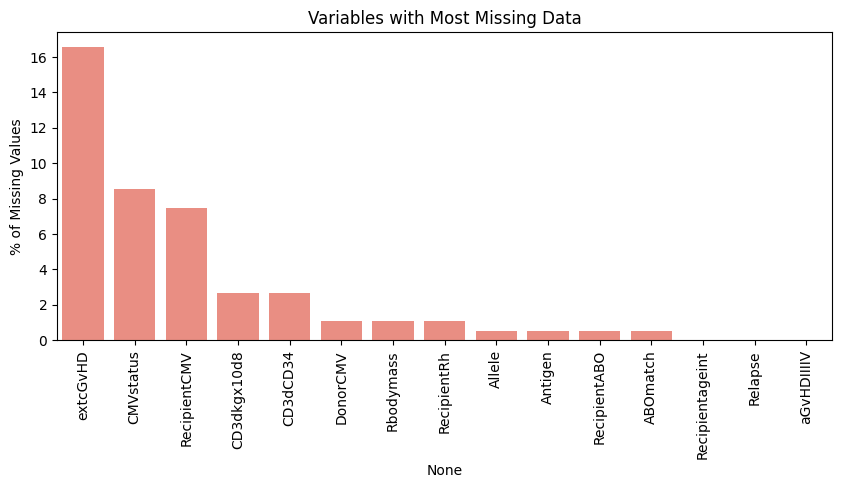

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Analyze Missing Values (NA)
na_counts = X.isna().sum().sort_values(ascending=False)
na_percent = (na_counts / len(X)) * 100

na_df = pd.DataFrame({
    'NA_count': na_counts,
    'NA_percent': na_percent
})
print("\nMissing Values Summary:")
display(na_df.head(10))

# Visualization of columns with most NA
plt.figure(figsize=(10,4))
sns.barplot(x=na_df.head(15).index, y=na_df.head(15)['NA_percent'], color='salmon')
plt.xticks(rotation=90)
plt.ylabel('% of Missing Values')
plt.title('Variables with Most Missing Data')
plt.show()

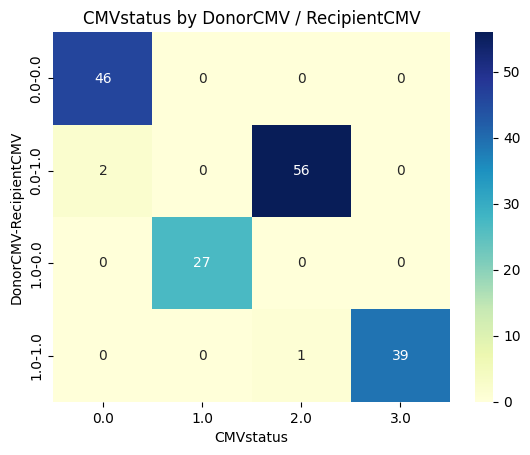

In [45]:
# Variables with NA to analyze
na_vars = [
    'extcGvHD', 'CMVstatus', 'RecipientCMV', 'CD3dCD34',
    'CD3dkgx10d8','CD34kgx10d6', 'Rbodymass', 'DonorCMV',
    'RecipientRh', 'ABOmatch', 'RecipientABO'
]

# Create the combined dataframe
eda_na_df = pd.concat([X[na_vars], y['survival_status']], axis=1)

# Create a table combining variables
plot_df = X[['DonorCMV', 'RecipientCMV', 'CMVstatus']].copy()
plot_df['extcGvHD_missing'] = X['extcGvHD'].isna().astype(int)
plot_df['survival_status'] = y['survival_status']

# Heatmap of CMVstatus by DonorCMV and RecipientCMV
ct = pd.crosstab([plot_df['DonorCMV'], plot_df['RecipientCMV']], plot_df['CMVstatus'])
sns.heatmap(ct, annot=True, fmt='d', cmap='YlGnBu')
plt.title('CMVstatus by DonorCMV / RecipientCMV')
plt.show()

In [46]:
# Change the type of RecipientRh to 'category'
X['RecipientRh'] = X['RecipientRh'].astype('category')

# Create Flag for missing extcGvHD
X['extcGvHD_missing'] = X['extcGvHD'].isna().astype(int)

# Fill the original variable with -1
X['extcGvHD'] = X['extcGvHD'].fillna(-1)

# Drop the DonorCMV and RecipientCMV Columns
X = X.drop(columns=['DonorCMV', 'RecipientCMV'])

# Create Flag for missing CMVstatus
X['CMVstatus_missing'] = X['CMVstatus'].isna().astype(int)
X['CMVstatus'] = X['CMVstatus'].fillna(-1)

# Impute rbodymass Nas with the median
median_rbodymass = X['Rbodymass'].median()
X['Rbodymass'] = X['Rbodymass'].fillna(median_rbodymass)
print(X['Rbodymass'].isna().sum())

# Impute RecipientRh Nas with the most frequent category (1)
X['RecipientRh'] = X['RecipientRh'].fillna(1)

# Eliminate rows with missing values in specific columns, as decided
X = X.dropna(subset=['RecipientABO'])
X = X.dropna(subset=['Antigen', 'Allele'])
y = y.drop([186, 129])

0


C:\Users\mario\AppData\Local\Temp\ipykernel_25548\3871628146.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['RecipientRh'] = X['RecipientRh'].astype('category')


## Regression model

In [47]:
# Correlation of numerical variables with CD3dkgx10d8
num_cols = X.select_dtypes(include=['number']).columns
corr = X[num_cols].corr()['CD3dkgx10d8'].sort_values(ascending=False)
print(corr)

CD3dkgx10d8             1.000000
CD34kgx10d6             0.586991
Stemcellsource          0.538541
RecipientABO            0.147197
extcGvHD                0.134032
DonorABO                0.101782
HLAgrI                  0.087984
CMVstatus_missing       0.082093
Allele                  0.074695
HLAmatch                0.061775
survival_time           0.055256
Antigen                 0.045433
HLAmismatch             0.033701
ABOmatch                0.021959
Gendermatch             0.021819
Riskgroup               0.016141
Donorage                0.006377
Txpostrelapse           0.004924
Recipientgender         0.001218
IIIV                   -0.003228
Donorage35             -0.015437
aGvHDIIIIV             -0.019409
CMVstatus              -0.033796
time_to_aGvHD_III_IV   -0.037262
Relapse                -0.077178
ANCrecovery            -0.100207
PLTrecovery            -0.113365
extcGvHD_missing       -0.120811
Diseasegroup           -0.178458
Recipientage10         -0.352108
CD3dCD34  

##### The imputation model for CD3dkgx10d8 was built using clinically and statistically relevant predictors. 
##### The most correlated variables were CD34kgx10d6 (r=0.58) and Stemcellsource (r=0.54), both biologically related to the cellular composition of the graft. Negative correlations with Rbodymass (r=-0.45) and Recipientage (r=-0.43) reflect normalization per kg and dose adjustment with patient age. 
##### The variable CD3dCD34 was excluded due to direct dependence on the target variable. The final model used: ['CD34kgx10d6', 'Stemcellsource', 'Rbodymass', 'Recipientage', 'Donorage', 'RecipientABO'].

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# The imputation model for CD3dkgx10d8 was built using the following predictors:
features = [
    'CD34kgx10d6',     
    'Stemcellsource',  
    'Rbodymass',       
    'Recipientage',    
    'Donorage',        
    'RecipientABO'     
]

# Build the model
df_model = X[features + ['CD3dkgx10d8']].copy()

# One-hot encode categorical variables
df_model = pd.get_dummies(df_model, columns=['Stemcellsource', 'RecipientABO'], drop_first=True)

# Split into training and prediction sets
df_train = df_model[df_model['CD3dkgx10d8'].notna()]
df_pred = df_model[df_model['CD3dkgx10d8'].isna()]
X_train = df_train.drop(columns=['CD3dkgx10d8'])
y_train = df_train['CD3dkgx10d8']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Train the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict and fill missing values
if not df_pred.empty:
    X_pred_scaled = scaler.transform(df_pred.drop(columns=['CD3dkgx10d8']))
    y_pred = model.predict(X_pred_scaled)
    X.loc[X['CD3dkgx10d8'].isna(), 'CD3dkgx10d8'] = y_pred

In [49]:
# There are missing values left in CD3dCD34
print(X['CD3dCD34'].isna().sum())

# Create a mask for remaining NA in CD3dCD34
mask_na = X['CD3dCD34'].isna()

# Fill the remaining missing values in CD3dCD34 by computing the ratio
X.loc[mask_na, 'CD3dCD34'] = (
    X.loc[mask_na, 'CD3dkgx10d8'] / X.loc[mask_na, 'CD34kgx10d6']
)

5


## Correlation between survival time and the numeric values

In [50]:
# Choose numeric columns
num_cols = X.select_dtypes(include=['float64', 'int64'])

# Correlations with survival_time
corr_time = num_cols.corr()['survival_time'].sort_values(ascending=False)
print(corr_time)

survival_time           1.000000
extcGvHD                0.468693
aGvHDIIIIV              0.147158
CD34kgx10d6             0.136518
time_to_aGvHD_III_IV    0.133633
CMVstatus               0.132455
HLAmismatch             0.077548
HLAmatch                0.051399
Antigen                 0.049901
CD3dCD34                0.048525
CD3dkgx10d8             0.047140
HLAgrI                  0.035461
Allele                  0.033735
ABOmatch                0.021383
Diseasegroup            0.014336
DonorABO                0.013502
Donorage                0.006846
Txpostrelapse          -0.003387
Donorage35             -0.037618
Stemcellsource         -0.039435
Riskgroup              -0.044523
Recipientgender        -0.057833
RecipientABO           -0.064627
Recipientageint        -0.065898
Recipientage10         -0.070531
IIIV                   -0.071457
Gendermatch            -0.101358
Recipientage           -0.131637
Rbodymass              -0.138674
Relapse                -0.166867
ANCrecover

##### When analyzing the correlation of variables with survival time, we found that the development of extensive chronic graft-versus-host disease (extcGvHD) has the strongest positive correlation (r = 0.47), indicating that patients who develop this condition tend to experience later events or longer survival. Other variables with moderate correlations include platelet recovery (PLTrecovery, r = -0.33). The remaining variables show weak or near-zero correlations with survival_time, so that individually they do not provide direct information about survival duration, though they could be relevant in multivariate or interaction models.

In [51]:
# Define the encode_disease function
def encode_disease(df, col='Disease', order='alphabetical'):
    """
    Encode categories of `col` to integer codes and add:
    order: 'alphabetical' or 'frequency' (most frequent = 0)
    Encoding mapping (code -> disease):
    0 -> ALL
    1 -> AML
    2 -> chronic
    3 -> lymphoma
    4 -> nonmalignant
    """

    s = df[col].astype(object)
    # Determine ordering of categories
    if order == 'alphabetical':
        s_sorted = sorted(s, key=lambda x: str(x).lower())
    elif order == 'frequency':
        s_sorted = s.value_counts(dropna=True).index.tolist()
    else:
        raise ValueError("Order must be 'alphabetical' or 'frequency'")

    mapping = {val: i for i, val in enumerate(s_sorted)}

    # Substitute the original column by its mapping in the dataframe
    df[col] = s.map(lambda v: mapping[v] if pd.notna(v) else -1).astype(int)

    return df, mapping

# Apply the chosen encoding to the 'Disease' column
X, disease_map = encode_disease(X, col='Disease', order='alphabetical')

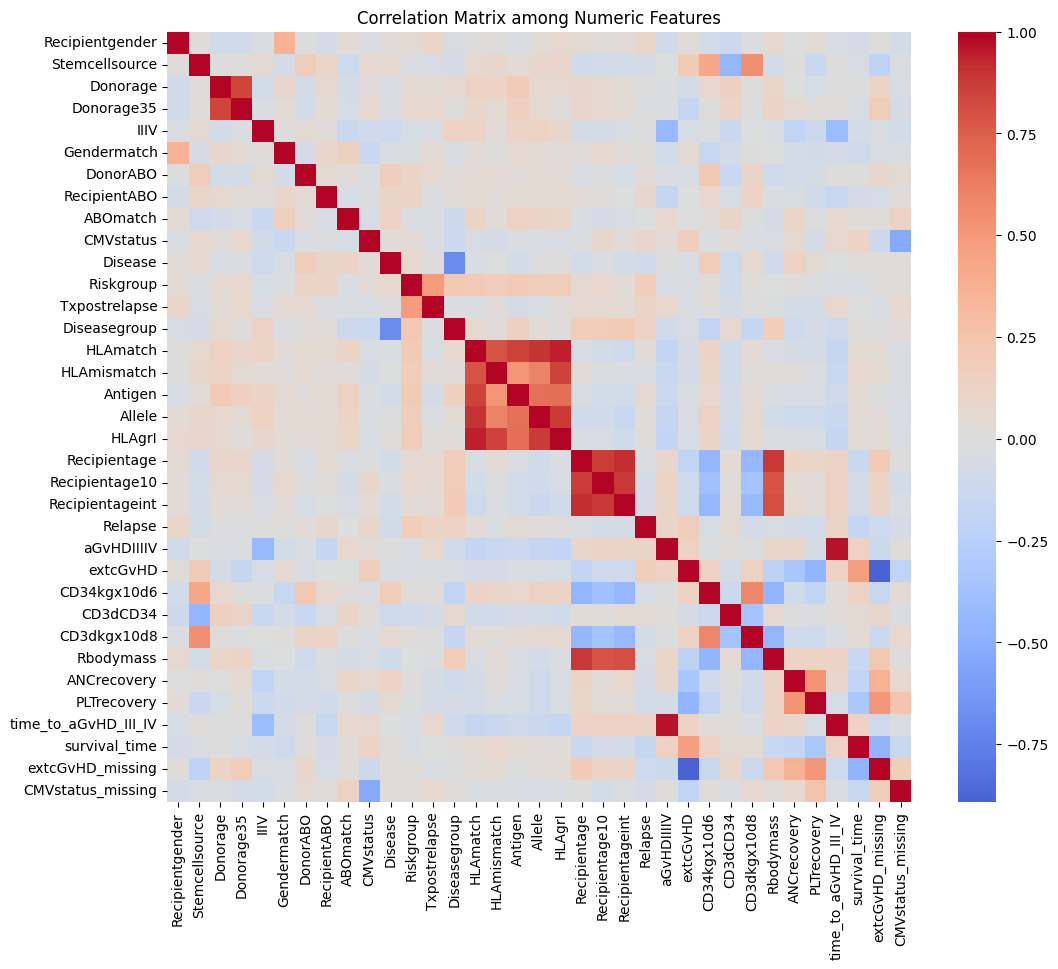

In [52]:
# Correlation matrix among numeric features
numeric_features = X.select_dtypes(include=[np.number])

plt.figure(figsize=(12,10))
sns.heatmap(numeric_features.corr(), cmap='coolwarm', center=0)
plt.title("Correlation Matrix among Numeric Features")
plt.show()

# PCA and Clustering

## PCA

In [53]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Use X_pca to perform the PCA
X_pca = X.copy()

# Select numeric columns only
num_cols = X_pca.select_dtypes(include=[np.number]).columns.tolist()
X_num = X_pca[num_cols].copy()

# Standardize the numeric features
scaler_pca = StandardScaler()
X_scaled = scaler_pca.fit_transform(X_num)

# Fit PCA model
pca = PCA()
X_pca_scores = pca.fit_transform(X_scaled)

print('PCA fitted on numeric features:', len(num_cols), 'features')
print('Explained variance ratios (first 10):', pca.explained_variance_ratio_[:10])

PCA fitted on numeric features: 35 features
Explained variance ratios (first 10): [0.14035259 0.12057893 0.08445641 0.06752305 0.05789389 0.05560338
 0.04970972 0.04584779 0.04214033 0.03871327]


## PCA Visualization

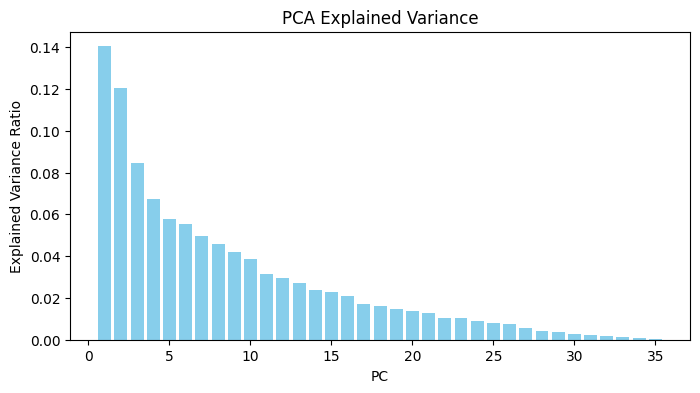

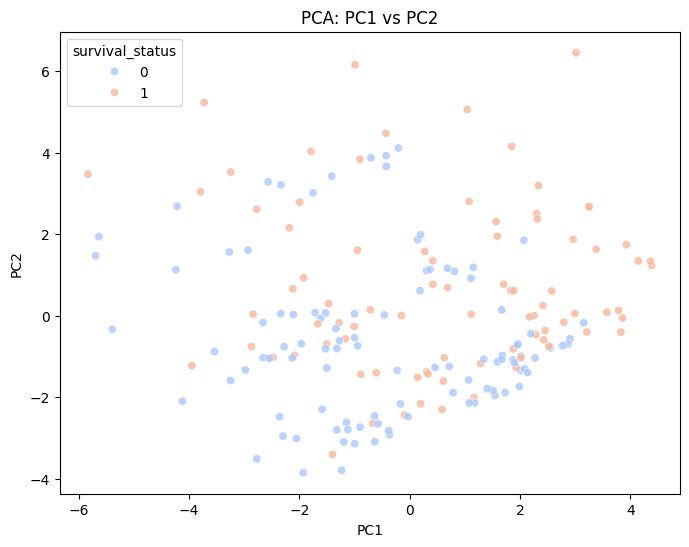

In [54]:
# Load PCA and scaler if available
from turtle import color

X_scaled = scaler_pca.transform(X_num)
X_scores = pca.transform(X_scaled)

# Explained variance plot
plt.figure(figsize=(8,4))
explained = pca.explained_variance_ratio_
plt.bar(range(1, len(explained)+1), explained, color='skyblue')
plt.xlabel('PC')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.show()

# 2D scatter (PC1 vs PC2)
plt.figure(figsize=(8,6))

# Color by survival_status if available
if 'survival_status' in globals() or 'survival_status' in locals():
    color = survival_status
elif 'y' in globals() and isinstance(y, (pd.DataFrame)) and 'survival_status' in y.columns:
    color = y['survival_status']
elif 'y' in globals() and isinstance(y, (pd.Series)):
    color = y

sns.scatterplot(x=X_scores[:,0], y=X_scores[:,1], hue=color, palette='coolwarm', alpha=0.8)
plt.legend(title='survival_status')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: PC1 vs PC2')
plt.show()

## Clustering

Running robust clustering: will recompute scaler & PCA on current numeric columns to avoid name mismatches.
Numeric columns used for PCA: 35
Selected features based on loadings on PC1 & PC2: ['HLAmatch', 'HLAgrI', 'Allele', 'Recipientage', 'Rbodymass', 'Antigen', 'Recipientageint', 'HLAmismatch']
k=2, silhouette=0.3120
k=3, silhouette=0.4064
k=4, silhouette=0.4361
k=5, silhouette=0.5062
k=6, silhouette=0.4896
Chosen k=5 with silhouette=0.5062
Saved clustered dataset to X_clustered.csv


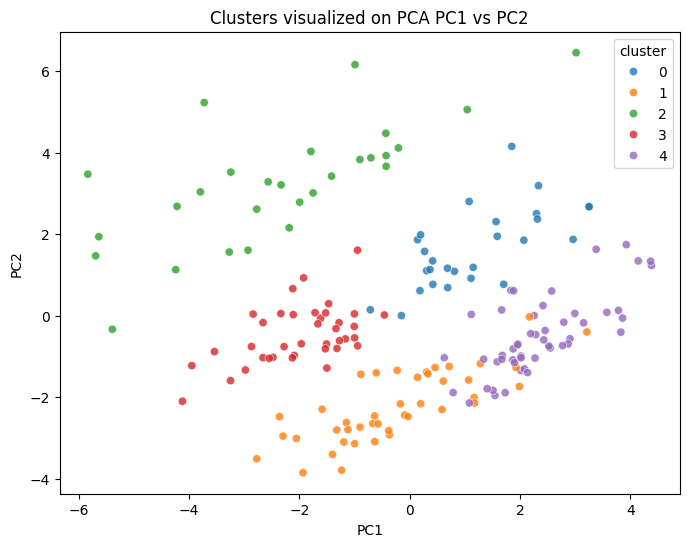

In [55]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib
import os

print('Running robust clustering: will recompute scaler & PCA on current numeric columns to avoid name mismatches.')

# Load data
if os.path.exists('X_imputed.csv'):
    X_full = pd.read_csv('X_imputed.csv')
else:
    try:
        X_full = X.copy()
    except Exception:
        from ucimlrepo import fetch_ucirepo
        ds = fetch_ucirepo(id=565)
        X_full = ds.data.features

# Ensure index is clean
X_full = X_full.reset_index(drop=True)

# Numeric columns
num_cols = X_full.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) < 2:
    raise RuntimeError('Not enough numeric columns to run PCA/clustering.')
X_num = X_full[num_cols]
print(f'Numeric columns used for PCA: {len(num_cols)}')

# Refit scaler and PCA on the current numeric data
scaler_pca = StandardScaler().fit(X_num)
X_scaled = scaler_pca.transform(X_num)

pca = PCA().fit(X_scaled)
# Save updated models
joblib.dump(scaler_pca, 'scaler_pca.pkl')
joblib.dump(pca, 'pca_model.pkl')

# Compute loadings
loadings = pd.DataFrame(pca.components_.T, index=num_cols, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
loadings['abs_PC12'] = loadings[['PC1','PC2']].abs().sum(axis=1)

# Select top features by contribution to PC1+PC2
n_select = 8
selected = loadings.sort_values('abs_PC12', ascending=False).head(n_select)
selected_features = selected.index.tolist()
print('Selected features based on loadings on PC1 & PC2:', selected_features)

# Scale selected features separately (safe)
X_sel = X_num[selected_features]
scaler_sel = StandardScaler().fit(X_sel)
X_sel_scaled = scaler_sel.transform(X_sel)
joblib.dump(scaler_sel, 'scaler_selected_features.pkl')

# Try KMeans for k=2..6 and pick best silhouette
best_k = None
best_score = -1
best_labels = None
for k in range(2,7):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_sel_scaled)
    try:
        score = silhouette_score(X_sel_scaled, labels)
    except Exception:
        score = -1
    print(f'k={k}, silhouette={score:.4f}')
    if score > best_score:
        best_score = score
        best_k = k
        best_labels = labels

if best_labels is None:
    raise RuntimeError('Clustering failed to produce labels')

print(f'Chosen k={best_k} with silhouette={best_score:.4f}')

# Save cluster assignments
X_full['cluster'] = best_labels
X_full.to_csv('X_clustered.csv', index=False)
print('Saved clustered dataset to X_clustered.csv')

# Plot clusters on PCA 2D space
scores = pca.transform(scaler_pca.transform(X_num))
plt.figure(figsize=(8,6))
sns.scatterplot(x=scores[:,0], y=scores[:,1], hue=best_labels, palette='tab10', alpha=0.8)
plt.title('Clusters visualized on PCA PC1 vs PC2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='cluster')
plt.show()

In [56]:
import os
import pandas as pd
import numpy as np

# Load clustered data (prefer saved CSV, otherwise fall back to in-memory variables)
if os.path.exists('X_clustered.csv'):
    df = pd.read_csv('X_clustered.csv')
else:
    try:
        df = X_full.copy()
    except Exception:
        try:
            df = X.copy()
        except Exception:
            raise RuntimeError("No clustered data found. Run clustering cell first or ensure 'X_clustered.csv' exists.")

# Basic checks
if 'cluster' not in df.columns:
    raise RuntimeError("`cluster` column not found. Run clustering first.")

# Ensure we have an original-row index column to identify members
if 'orig_index' not in df.columns:
    df = df.reset_index().rename(columns={'index': 'orig_index'})

# Choose numeric columns to describe clusters
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in ('cluster', 'orig_index')]

overall_mean = df[num_cols].mean() if num_cols else pd.Series(dtype=float)
overall_std = df[num_cols].std(ddof=0).replace(0, np.nan) if num_cols else pd.Series(dtype=float)

summary_rows = []
print("Detailed cluster descriptions:")

for cl in sorted(df['cluster'].unique()):
    members = df[df['cluster'] == cl]
    n = len(members)
    print("\n" + "="*72)
    print(f"Cluster {cl} — {n} members")
    if 'survival_status' in df.columns:
        counts = members['survival_status'].value_counts().to_dict()
        props = members['survival_status'].value_counts(normalize=True).round(3).to_dict()
        print("survival_status counts:", counts)
        print("survival_status proportions:", props)

    # Top numeric features that differ from overall (by absolute z-difference)
    top_feats = []
    if num_cols:
        cl_mean = members[num_cols].mean()
        std_diff = ((cl_mean - overall_mean) / overall_std).abs().sort_values(ascending=False)
        std_diff = std_diff.dropna()
        top_feats = std_diff.head(5).index.tolist()
        if top_feats:
            print("\nTop numeric features (by absolute standardized difference vs overall):")
            for f in top_feats:
                z = ((cl_mean[f] - overall_mean[f]) / (overall_std[f] if not pd.isna(overall_std[f]) else np.nan))
                print(f"  {f}: cluster_mean={cl_mean[f]:.3f}, overall_mean={overall_mean[f]:.3f}, z_diff={z:.3f}")
        else:
            print("\nNo numeric features with sufficient variation to show.")
    else:
        print("\nNo numeric features available to describe clusters.")

    # Member listing: original indices and a small sample table
    display_cols = ['orig_index'] + [c for c in ['survival_time', 'survival_status', 'DonorAge', 'Recipientage'] if c in df.columns]
    idxs = members['orig_index'].tolist()
    if len(idxs) > 50:
        print("\nMember orig_index (first 50 shown):")
        print(idxs[:50])
    else:
        print("\nMember orig_index:")
        print(idxs)

    if display_cols:
        print("\nSample rows for this cluster (first 10 rows):")
        print(members[display_cols].head(10).to_string(index=False))

    # Append summary row for the CSV summary table
    summary_rows.append({
        'cluster': int(cl),
        'size': int(n),
        'top_features': ','.join(top_feats) if top_feats else ''
    })

# Save and show overall summary table
summary_df = pd.DataFrame(summary_rows).sort_values('cluster')

Detailed cluster descriptions:

Cluster 0 — 27 members

Top numeric features (by absolute standardized difference vs overall):
  Recipientage10: cluster_mean=0.963, overall_mean=0.470, z_diff=0.987
  Recipientageint: cluster_mean=1.963, overall_mean=1.222, z_diff=0.899
  Rbodymass: cluster_mean=52.615, overall_mean=35.639, z_diff=0.869
  Recipientage: cluster_mean=14.322, overall_mean=9.892, z_diff=0.838
  Allele: cluster_mean=0.407, overall_mean=-0.243, z_diff=0.732

Member orig_index:
[15, 16, 20, 21, 23, 40, 46, 60, 62, 65, 69, 73, 75, 83, 84, 89, 102, 118, 124, 132, 137, 147, 152, 153, 156, 173, 176]

Sample rows for this cluster (first 10 rows):
 orig_index  survival_time  Recipientage
         15           3288          13.5
         16             58          17.9
         20            115          14.7
         21            330           9.7
         23            149          10.9
         40           1376          13.8
         46           1006          11.3
         60  

## Kaplan-Meier and Cox Regression

## Kaplan-Meier

In [57]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load clustered data
if os.path.exists('X_clustered.csv'):
    df = pd.read_csv('X_clustered.csv')
else:
    # fall back to in-memory variables if available
    try:
        df = X_full.copy()
    except Exception:
        try:
            df = X.copy()
        except Exception:
            raise RuntimeError("No clustered dataset found. Run the clustering cell or ensure 'X_clustered.csv' exists.")

# Ensure survival columns present: try to attach y if needed
if 'survival_time' not in df.columns or 'survival_status' not in df.columns:
    try:
        y_df = y.copy()
        df = pd.concat([df.reset_index(drop=True), y_df.reset_index(drop=True)], axis=1)
    except Exception:
        pass

# Basic checks
if 'cluster' not in df.columns:
    raise RuntimeError("No 'cluster' column found in the data. Run clustering first.")
if 'survival_time' not in df.columns or 'survival_status' not in df.columns:
    raise RuntimeError("Both 'survival_time' and 'survival_status' must be present for survival analysis.")

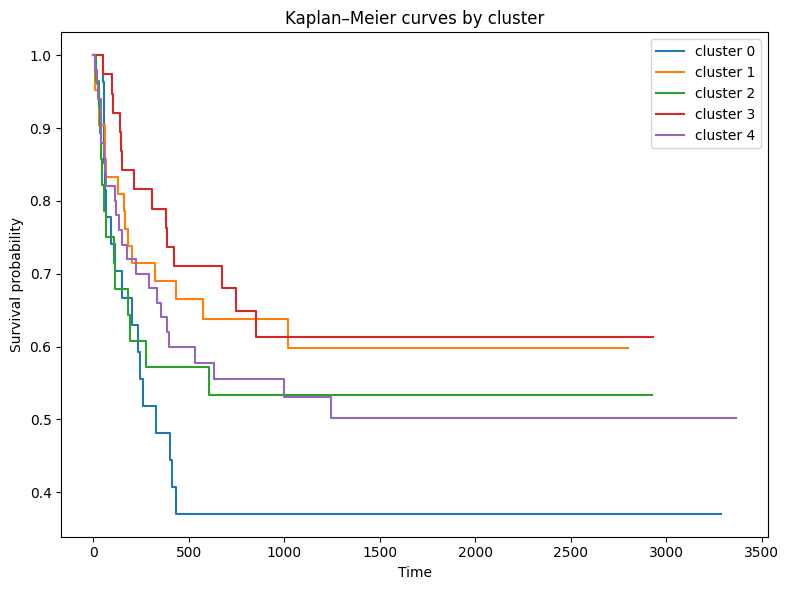

Saved KM plot to 'km_clusters.png'


In [58]:
# Kaplan–Meier curves by cluster
clusters = sorted(df['cluster'].unique())
plt.figure(figsize=(8,6))
colors = sns.color_palette('tab10', n_colors=len(clusters))

# Simple manual KM step-plot fallback
for i, c in enumerate(clusters):
    mask = df['cluster'] == c
    T = df.loc[mask, 'survival_time'].values
    E = df.loc[mask, 'survival_status'].values
    if len(T) == 0:
        continue
    order = np.argsort(T)
    T_sorted = T[order]
    E_sorted = E[order]
    n = len(T_sorted)
    at_risk = n - np.arange(n)
    # handle zeros in at_risk
    with np.errstate(divide='ignore', invalid='ignore'):
        surv = np.cumprod(1 - (E_sorted / at_risk))
    # prepend time=0, surv=1 for plotting
    times = np.concatenate(([0.0], T_sorted))
    surv_plot = np.concatenate(([1.0], surv))
    plt.step(times, surv_plot, where='post', label=f'cluster {c}', color=colors[i])

plt.xlabel('Time')
plt.ylabel('Survival probability')
plt.title('Kaplan–Meier curves by cluster')
plt.legend()
plt.tight_layout()
plt.savefig('km_clusters.png', dpi=150)
plt.show()
print("Saved KM plot to 'km_clusters.png'")

## Cox Regression

In [59]:
# Build Cox dataframe with survival_time, event, and one-hot cluster indicators
cox_df = df[['survival_time', 'survival_status', 'cluster']].copy()
cox_df = pd.get_dummies(cox_df, columns=['cluster'], drop_first=True)  # reference = lowest cluster
cox_out_csv = 'cox_cluster_only.csv'

print("Interpretation summary (cluster-only survival analysis):\n")

# Cluster sizes
if os.path.exists('cluster_sizes.csv'):
    sizes = pd.read_csv('cluster_sizes.csv')
    print("Cluster sizes:")
    for _, r in sizes.iterrows():
        print(f" - Cluster {int(r['cluster'])}: {int(r['size'])} members")
else:
    print(" - cluster_sizes.csv not found. Run the analysis cell first.")

# KM plot info
if os.path.exists('km_clusters.png'):
    print("\n - Kaplan–Meier plot saved to 'km_clusters.png'. Inspect visually for separation between clusters.")
else:
    print("\n - KM plot not found.")

# Pairwise log-rank results
if os.path.exists('logrank_pairwise.csv'):
    lr = pd.read_csv('logrank_pairwise.csv')
    # mark significance at alpha=0.05
    lr['significant'] = lr['p_value'] < 0.05
    print("\nPairwise log-rank tests (sorted by p-value):")
    display(lr)
    sig = lr[lr['significant']]
    if not sig.empty:
        print("\nSignificant pairwise differences (p < 0.05):")
        for _, row in sig.iterrows():
            print(f" - Cluster {int(row['groupA'])} vs Cluster {int(row['groupB'])}: p = {row['p_value']:.4g}")
    else:
        print("\nNo pairwise comparisons reached p < 0.05 (unadjusted).")
else:
    print("\n - logrank_pairwise.csv not found (log-rank tests may have been skipped).")

# Cox cluster-only results
if os.path.exists('cox_cluster_only.csv'):
    cox = pd.read_csv('cox_cluster_only.csv')
    # try to read common columns (coef, exp(coef), p)
    print("\nCox (cluster-only) summary (from 'cox_cluster_only.csv'):")
    display(cox)
    # check for significant covariates
    pcols = [c for c in cox.columns if 'p' in c.lower()]
    if pcols:
        pcol = pcols[0]
        sig_cox = cox[cox[pcol] < 0.05]
        if not sig_cox.empty:
            print("\nClusters with significant hazard ratios (p < 0.05):")
            for _, row in sig_cox.iterrows():
                cov = row.get('covariate', row.index)
                hr = row.get('exp(coef)', row.get('exp(coef)', np.nan))
                pval = row[pcol]
                print(f" - {cov}: HR ≈ {hr:.3g}, p={pval:.4g}")
        else:
            print("\nNo cluster indicators were statistically significant at p < 0.05 (unadjusted).")
    else:
        print("\nCould not locate p-value column in cox_cluster_only.csv to assess significance.")
else:
    print("\n - cox_cluster_only.csv not found (Cox may have been skipped).")

# Short plain-English interpretation template you can paste into your report
print("\nSuggested plain-English interpretation (template):")
print("-----------------------------------------------")
print("We partitioned patients into clusters using unsupervised feature-based clustering, then compared survival across clusters.")
print("The Kaplan–Meier curves (see 'km_clusters.png') show whether clusters separate in survival over time.")
if os.path.exists('logrank_pairwise.csv'):
    print("Pairwise log-rank tests identify which cluster pairs differ (see 'logrank_pairwise.csv'); treat p-values as unadjusted.")
if os.path.exists('cox_cluster_only.csv'):
    print("A Cox model with cluster indicators quantifies hazard ratios for each cluster vs the reference (see 'cox_cluster_only.csv').")
print("\nCaution: clusters were derived from the same dataset. Treat findings as descriptive subgroup differences and validate on independent data where possible.")
print("-----------------------------------------------")

Interpretation summary (cluster-only survival analysis):

 - cluster_sizes.csv not found. Run the analysis cell first.

 - Kaplan–Meier plot saved to 'km_clusters.png'. Inspect visually for separation between clusters.

 - logrank_pairwise.csv not found (log-rank tests may have been skipped).

 - cox_cluster_only.csv not found (Cox may have been skipped).

Suggested plain-English interpretation (template):
-----------------------------------------------
We partitioned patients into clusters using unsupervised feature-based clustering, then compared survival across clusters.
The Kaplan–Meier curves (see 'km_clusters.png') show whether clusters separate in survival over time.

Caution: clusters were derived from the same dataset. Treat findings as descriptive subgroup differences and validate on independent data where possible.
-----------------------------------------------


## Survival & cluster profiling

1) Cluster sizes
- Cluster counts are saved in `cluster_sizes.csv`. In this run the clusters sizes were: 0:27, 1:42, 2:28, 3:38, 4:50. Note cluster sizes when interpreting statistical tests: small clusters reduce power.

2) Kaplan–Meier and log-rank
- The KM curves (saved to `km_clusters.png`) visually display survival probability by cluster. Pairwise log-rank tests (saved to `logrank_pairwise.csv`) show which cluster pairs differ significantly. In this run, cluster 0 vs 3 had p=0.043 (suggesting a statistically significant difference at α=0.05). Other pairs were not significant after unadjusted testing.

3) Cox proportional hazards — cluster-only model
- The Cox model used cluster indicators only (reference = cluster 0). Results saved to `cox_cluster_only.csv` show hazard ratios (exp(coef)) for each cluster vs the reference: e.g., cluster_3 HR ≈ 0.497 (coef = -0.699), p≈0.056. This suggests cluster 3 had about half the hazard of cluster 0, though p=0.056 is marginal (slightly above 0.05).
- Concordance index ≈ 0.568 indicates modest discriminative ability (better than random but far from perfect).

4) Interpretation guidance
- Both KM and Cox show cluster differences; Cox quantifies the adjusted hazard (here adjustment is trivial because the model includes cluster indicators only). Because clusters were formed from patient features, these results indicate that the discovered patient groups differ in survival risk.
- Caution: clusters are derived from the same data, not from an external partition — report them as descriptive subgroups and validate in an independent dataset if possible.